In [1]:
import numpy as np
import torch
from torch import Tensor, meshgrid
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
dtype=torch.float

%matplotlib inline

Activation function

In [2]:
# for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class nnSin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

## $\frac{\partial f}{\partial x}$
Defining autograd and perturbation of points

In [3]:
# Define some more general functions
def df_dx(f,x):
    """ Calculate the derivative with auto-differention """
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def perturbPoints(grid,x0,xf,sig=0.5):
    """ stochastic perturbation of the evaluation points
    it forces boundary conditions after pertrubation
    
    x[0] = x0
    x[-1] = xf 

    """
    dx = grid[1] - grid[0]  
    noise = dx * torch.randn_like(grid)*sig
    x = grid + noise
    
    # boundary conditions
    x.data[0] = torch.ones(1,1)*x0
    x.data[-1] = torch.ones(1,1)*xf
    x.requires_grad = False

    return x

In [4]:
# Define the grid
x0 = -6
xf = 6
num_points = 100
grid = torch.linspace(x0, xf, num_points)

# Perturb the grid
perturbed_grid = perturbPoints(grid, x0, xf, sig=0.9)

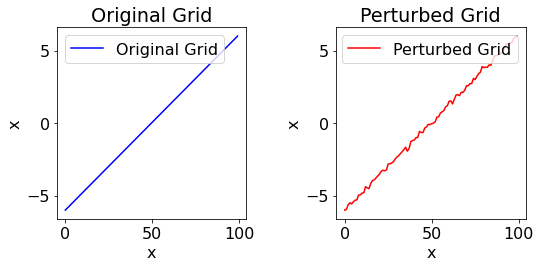

In [5]:
# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(grid, 'b', label='Original Grid')
plt.xlabel('x')
plt.ylabel('x')
plt.title('Original Grid')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(perturbed_grid, 'r', label='Perturbed Grid')
plt.xlabel('x')
plt.ylabel('x')
plt.title('Perturbed Grid')
plt.legend()

plt.tight_layout()
plt.show()


generate throught a grid

c:\Users\fbien.DESKTOP-6FMEAR7\.conda\envs\deepl\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


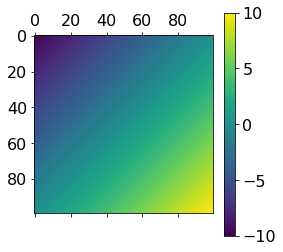

In [6]:
xL, xR = -5, 5
yL, yR = -5, 5
Npoints = 100

x = Tensor([x for x in np.linspace(xL, xR, Npoints)])
y = Tensor([y for y in np.linspace(yL, yR, Npoints)])

grid_x, grid_y = meshgrid(x,y)


cax = plt.matshow(grid_x + grid_y)
plt.gcf().colorbar(cax)
plt.show()

In [7]:
# agregar seguimiento de gradientes
x.requires_grad_()
y.requires_grad_();

## $\Psi$ section

In [8]:
def psi_parametric([nn], x, x0, xf, fb):
    """
    nn: model
    x: points
    xL, xR: boundaries
    fb: boundarie value (assuming simetry)
    """
    # parametric solutions  Psi(x)
    Psi = nn(x)

    # parametric function
    g = (1-torch.exp(-(x - xL)))*(1-torch.exp(-(x - xR)))
        # g(tL) = 0
        # g(tR) = 0

    # parametrized souliton with boundaries
    f_hat  = fb  + g* Psi
    return f_hat

# Differential equation loss
def physics_loss(x, psi, E, V):
    # derivative with respect to grid
    psi_dx = df_dx(psi, x)
    psi_ddx= df_dx(psi_dx, x)
    
    # this represents the physics equation
    Hamiltonian_eq0 = psi_ddx/2 + (E-V)*psi
    Loss_DE  = (Hamiltonian_eq0.pow(2)).mean(); # mean of loss
    return Loss_DE

### V
Potential as supperposition of orthogonal functions

$$
V(x) = \sum_{l = 0}^\infty P_l
$$

Why Legendre Polynomials?
- is between simple and general enough
- a normalized basis of position ends up in $x \in [-1,1]$ which is the domain of this polynomials.

For higher dimensions the potential should be implemented with this same strategy

In [9]:
import sympy as sm
import numpy as np
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt

In [10]:
coef = Tensor([9,1,3,5,0,0,0,1,0])
coef

tensor([9., 1., 3., 5., 0., 0., 0., 1., 0.])

In [11]:
Legendre(coef, domain=[xL,xR])

Legendre([9., 1., 3., 5., 0., 0., 0., 1., 0.], dtype=float32, domain=[-5.,  5.], window=[-1,  1])

In [12]:
# f1 = f1(x)
# using our coefficients array
f1 = Legendre(coef, domain=[xL,xR])

x0 = 3
f1(x0)

8.2425984

Generar varios potenciales de manera facil y controlada

In [13]:
f1(x).detach().numpy()

array([ 4.999999 ,  5.923813 ,  6.6913724,  7.3252068,  7.845338 ,
        8.269505 ,  8.613314 ,  8.890439 ,  9.112754 ,  9.290506 ,
        9.432457 ,  9.546016 ,  9.637382 ,  9.711657 ,  9.772966 ,
        9.8245735,  9.86897  ,  9.907986 ,  9.942873 ,  9.974382 ,
       10.002858 , 10.02829  , 10.050395 , 10.068667 , 10.082442 ,
       10.0909395, 10.09331  , 10.088681 , 10.076186 , 10.055    ,
       10.024366 ,  9.983618 ,  9.9321995,  9.869684 ,  9.795785 ,
        9.7103615,  9.613432 ,  9.505171 ,  9.385913 ,  9.256152 ,
        9.116534 ,  8.9678545,  8.811045 ,  8.64717  ,  8.477408 ,
        8.303047 ,  8.1254635,  7.946109 ,  7.766495 ,  7.5881786,
        7.4127398,  7.2417693,  7.076848 ,  6.919532 ,  6.7713327,
        6.6337028,  6.508019 ,  6.3955665,  6.297527 ,  6.2149625,
        6.1488066,  6.099854 ,  6.0687504,  6.0559897,  6.0619063,
        6.086676 ,  6.130316 ,  6.1926856,  6.2734995,  6.372328 ,
        6.488617 ,  6.6217012,  6.7708225,  6.935156 ,  7.1138

In [14]:
x.detach().numpy()

array([-5.        , -4.8989897 , -4.79798   , -4.6969695 , -4.5959597 ,
       -4.4949493 , -4.3939395 , -4.292929  , -4.1919193 , -4.090909  ,
       -3.989899  , -3.8888888 , -3.7878788 , -3.6868687 , -3.5858586 ,
       -3.4848485 , -3.3838384 , -3.2828283 , -3.1818182 , -3.0808082 ,
       -2.979798  , -2.878788  , -2.7777777 , -2.6767676 , -2.5757575 ,
       -2.4747474 , -2.3737373 , -2.2727273 , -2.1717172 , -2.070707  ,
       -1.969697  , -1.8686869 , -1.7676767 , -1.6666666 , -1.5656565 ,
       -1.4646465 , -1.3636364 , -1.2626263 , -1.1616162 , -1.060606  ,
       -0.959596  , -0.85858583, -0.75757575, -0.65656567, -0.5555556 ,
       -0.45454547, -0.35353535, -0.25252524, -0.15151516, -0.05050505,
        0.05050505,  0.15151516,  0.25252524,  0.35353535,  0.45454547,
        0.5555556 ,  0.65656567,  0.75757575,  0.85858583,  0.959596  ,
        1.060606  ,  1.1616162 ,  1.2626263 ,  1.3636364 ,  1.4646465 ,
        1.5656565 ,  1.6666666 ,  1.7676767 ,  1.8686869 ,  1.96

In [15]:
# x as a meshgrid
coef = Tensor([np.random.randint(10) for i in range(5)])
coef.requires_grad_()
f1 = Legendre(coef.detach().numpy(), domain=[xL,xR])

# el problema es que al aplicar Legendre como funcion perdemos el poder tensorial

In [16]:
f1(x)

tensor([-6.0000e+00, -5.5208e+00, -5.0531e+00, -4.5977e+00, -4.1550e+00,
        -3.7255e+00, -3.3096e+00, -2.9079e+00, -2.5206e+00, -2.1482e+00,
        -1.7910e+00, -1.4492e+00, -1.1231e+00, -8.1290e-01, -5.1882e-01,
        -2.4099e-01,  2.0483e-02,  2.6552e-01,  4.9409e-01,  7.0618e-01,
         9.0181e-01,  1.0811e+00,  1.2440e+00,  1.3908e+00,  1.5216e+00,
         1.6367e+00,  1.7362e+00,  1.8204e+00,  1.8896e+00,  1.9443e+00,
         1.9846e+00,  2.0112e+00,  2.0244e+00,  2.0247e+00,  2.0126e+00,
         1.9887e+00,  1.9536e+00,  1.9078e+00,  1.8521e+00,  1.7871e+00,
         1.7136e+00,  1.6324e+00,  1.5441e+00,  1.4497e+00,  1.3501e+00,
         1.2461e+00,  1.1387e+00,  1.0288e+00,  9.1743e-01,  8.0569e-01,
         6.9462e-01,  5.8534e-01,  4.7900e-01,  3.7678e-01,  2.7990e-01,
         1.8961e-01,  1.0719e-01,  3.3975e-02, -2.8680e-02, -7.9384e-02,
        -1.1671e-01, -1.3919e-01, -1.4533e-01, -1.3360e-01, -1.0242e-01,
        -5.0207e-02,  2.4692e-02,  1.2394e-01,  2.4

In [17]:
# generar en 2D
# x as a meshgrid
coefx = Tensor([np.random.randint(10) for i in range(5)])
coefy = Tensor([np.random.randint(10) for i in range(5)])
fx = Legendre(coefx.detach().numpy(), domain=[xL,xR])
fy = Legendre(coefy.detach().numpy(), domain=[yL,yR])


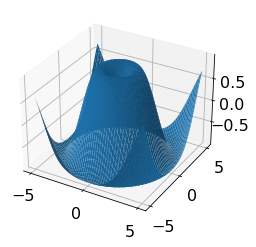

In [18]:
import matplotlib.pyplot as plt
xs = torch.linspace(xL, xR, steps=100)
ys = torch.linspace(yL, yR, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = torch.sin(torch.sqrt(x * x + y * y))
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
plt.show()


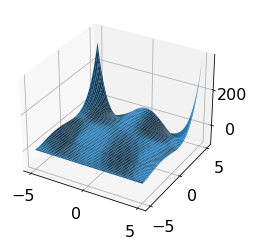

In [19]:
xs = torch.linspace(xL, xR, steps=100)
ys = torch.linspace(yL, yR, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = fx(x) * fy(y)
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
plt.show()

Generar varios 2D

$$
V(x,y) = \sum_{n,m} P_n(x) P_m(y)
$$

In [23]:
xs = torch.linspace(xL, xR, steps=100)
ys = torch.linspace(yL, yR, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')

In [35]:
Nl = 15 # polinom legendre max

coefx = Tensor([np.random.randint(10)* (1/(i+1)) for i in range(Nl)])
coefy = Tensor([np.random.randint(10)* (1/(i+1)) for i in range(Nl)])

coefx.requires_grad_()
coefy.requires_grad_()

fx = Legendre(coefx, domain=[xL,xR])
fy = Legendre(coefy, domain=[yL,yR])
z = fx(x) * fy(y)
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

- [ ] implementar generacion de polinomios de legendre con pytorch

Generar Legendre

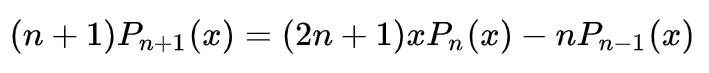

In [37]:
P0 = lambda x: 1
P1 = lambda x: x

def P_n1(x, Pn, P_n_1):
    return ((2 * n + 1) * x * Pn(x) - n * P_n_1(x))/(n+1)


## NN section

In [22]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        # Define the Activation
        self.actF = nnSin()


        

    def forward(self, x, psi, E_n):
        """
        x: 1D grid
        psi: wave function
        E_n: scalar with eigenvalue (known)
        """
        x1 = self.features(x)
        x2 = self.features(y)
        x = torch.cat((x1, x2), 1)
        return post_psi

NameError: name 'nn' is not defined

In [ ]:
class Net(nn.Module):
    def __init__( self,
        input_dim, output_dim, n_units=100,
        loss=nn.MSELoss(), loss2=None, loss2_weight=0.1) -> None:
        super().__init__()

        # parametros utiles dentro de la red
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.n_units = n_units

        # Layers compuestas por ReLU simples
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim) # una capa que combine todo

    def forward(self, x): # metodo de forward simple
        h = self.layers(x)
        out = self.out(h)
        return out

    def fit(self, X, y, optimizer, epochs): # fitting function
        Xt = np_to_torch_tensor(X)
        yt = np_to_torch_tensor(y)

        self.train() # se activa el modo de entrenamiento
        losses = [] # array de loss's

        for ep in range(epochs):
            optimizer.zero_grad() 
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2: # funcion de perdida extra
                loss += self.loss2_weight * self.loss2(self)
            
            loss.backward()  # recorre el grafico y obtiene derivadas parciales
            optimizer.step()  # usa la información para actualizar parametros

            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")

        return losses

    def predict(self, X):
        self.eval() # modo de evaluación no genera graficos de pasos en torch
        out = self.forward(np_to_torch_tensor(X))
        return out.detach().cpu().numpy()


In [ ]:
class forward_network(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(forward_network,self).__init__()

        # Define the Activation
        self.actF = nnSin()
        
        # layers
        self.Ein    = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.out    = torch.nn.Linear(D_hid, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))
        L1 = self.Lin_1(torch.cat((t,In1),1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        out = self.out(h2)
        return out, In1



In [ ]:
def potential(Xs, k=4):
  """Gives the potential at each point
  Takes in tensor of x points, gives back tensor of V at each point"""

  Xsnp = Xs.data.numpy()
  Vnp = k*Xsnp**2/2
  Vtorch = torch.from_numpy(Vnp)
  return Vtorch


In [ ]:
# Train the NN
def run_Scan_oscillator(t0, tf, x1, neurons, epochs, n_train,lr, minibatch_number = 1):
    fc0 = qNN1(neurons)
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = [];     Llim =  1e+20
    En_loss_history = []
    boundary_loss_history = []
    nontriv_loss_history = []
    SE_loss_history = []
    Ennontriv_loss_history = []
    criteria_loss_history = []
    En_history = []
    EWall_history = []
    di = (None, 1e+20)
    dic = {0:di, 1:di, 2:di, 3:di, 4:di, 5:di , 6:di, 7:di, 8:di, 9:di, 10:di, 11:di, 12:di, 13:di, 14:di, 15:di, 16:di}
    
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)
    
    ## TRAINING ITERATION    
    TeP0 = time.time()
    walle = -2
    last_psi_L = 0
    for tt in range(epochs): 
        #adjusting learning rate at epoch 3e4
        #if tt == 3e4:
        #    optimizer = optim.Adam(fc0.parameters(), lr = 1e-2, betas = betas)
# Perturbing the evaluation points & forcing t[0]=t0
        t=perturbPoints(grid,t0,tf,sig=.03*tf)
            
# BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f=t[-1]
        t_f=t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss=0.0


        for nbatch in range(minibatch_number): 
# batch time set
            t_mb = t_b[batch_start:batch_end]

#  Network solutions 
            nn, En = fc0(t_mb)

            En_history.append(En[0].data.tolist()[0])

            psi  = parametricSolutions(t_mb, fc0, t0, x1) #- last_psi_L*torch.exp(-(torch.ones_like(t_mb)-1)**2/(2*(1/20)))
            #last_psi_L = parametricSolutions(torch.ones_like(t_mb),fc0,t0,x1).data.numpy()[0][0]
            #print(last_psi_L)
            Pot = potential(t_mb)
            Ltot = hamEqs_Loss(t_mb, psi, En, Pot)
            SE_loss_history.append(Ltot) #
            
            criteria_loss =  Ltot

            if tt%1000 == 0:
              walle += 0.16
            Ltot += 1/((psi.pow(2)).mean()+1e-6) + 1/(En.pow(2).mean()+1e-6) + torch.exp(-1*En+walle).mean()
            En_loss_history.append(torch.exp(-1*En+walle).mean()) #
            EWall_history.append(walle)

            
            nontriv_loss_history.append(1/((psi.pow(2)).mean()+1e-6)) #
            Ennontriv_loss_history.append(1/(En.pow(2).mean()+1e-6)) #
# OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step(); loss += Ltot.data.numpy()
            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

# keep the loss function history
        Loss_history.append(loss)       

#Keep the best model (lowest loss) by using a deep copy
        if  criteria_loss < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=criteria_loss

        E_bin = abs(En[0].data.tolist()[0]//2) 
        if criteria_loss < dic[E_bin][1]:
          dic[E_bin] = (copy.deepcopy(fc0), criteria_loss)

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history, criteria_loss_history, fc0, En_history, EWall_history, dic)
    return fc1, loss_histories, runTime

In [ ]:
## Train the model 

t0 = -6
tf = 6
xBC1=0.

n_train, neurons, epochs, lr,mb = 1200, 50, int(5e4), 8e-3, 1 
model1,loss_hists1,runTime1 = run_Scan_oscillator(
    t0, tf, xBC1, neurons, epochs, n_train, lr, mb
    )

RuntimeError: The expanded size of the tensor (1) must match the existing size (0) at non-singleton dimension 0.  Target sizes: [1].  Tensor sizes: [0]